### Training and Prediction Example

Training and prediction explained in more detail.  
Demonstrates how to predict the evolution of a system state that does not 
directly follow the training data.

Import packages, create an ESN object

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rescomp

esn = rescomp.ESNWrapper()

simulate some data

In [2]:
simulation_time_steps = 20000
starting_point = np.array([-14.03020521, -20.88693127, 25.53545])
sim_data = rescomp.simulate_trajectory(
    sys_flag='lorenz', dt=2e-2, time_steps=simulation_time_steps,
    starting_point=starting_point)

and create the internal network

In [3]:
esn.create_network()

For this example, let's use the same number of time steps for the training as in the [minimal example](minimal_example.ipynb) before

In [5]:
train_sync_steps = 400
train_steps = 4000

Let's cut the input data accordingly

In [6]:
x_train = sim_data[: train_sync_steps + train_steps]

And plug it in the train() method

In [7]:
esn.train(x_train=sim_data, sync_steps=train_sync_steps) # DD: shouldnt it be x_train = x_train?

Now that the reservoir is trained, we want to predict the system evolution not
directly after the training data (after 4400 time steps of simulated data) but instead sometime later.
Let's say we want to predict the evolution after 10000 time steps instead.

In [8]:
shift = 10000
x_pred = sim_data[shift:]

Due to this disconnect, we must synchronize the internal reservoir states with
the system again before we can use it to predict anything.
Let's again synchronize for 400 steps and predict for 500

In [9]:
pred_sync_steps = 400
pred_steps = 500  
y_pred, y_test = esn.predict(x_pred=x_pred, sync_steps=pred_sync_steps,
                             pred_steps=pred_steps)

Plot the prediction

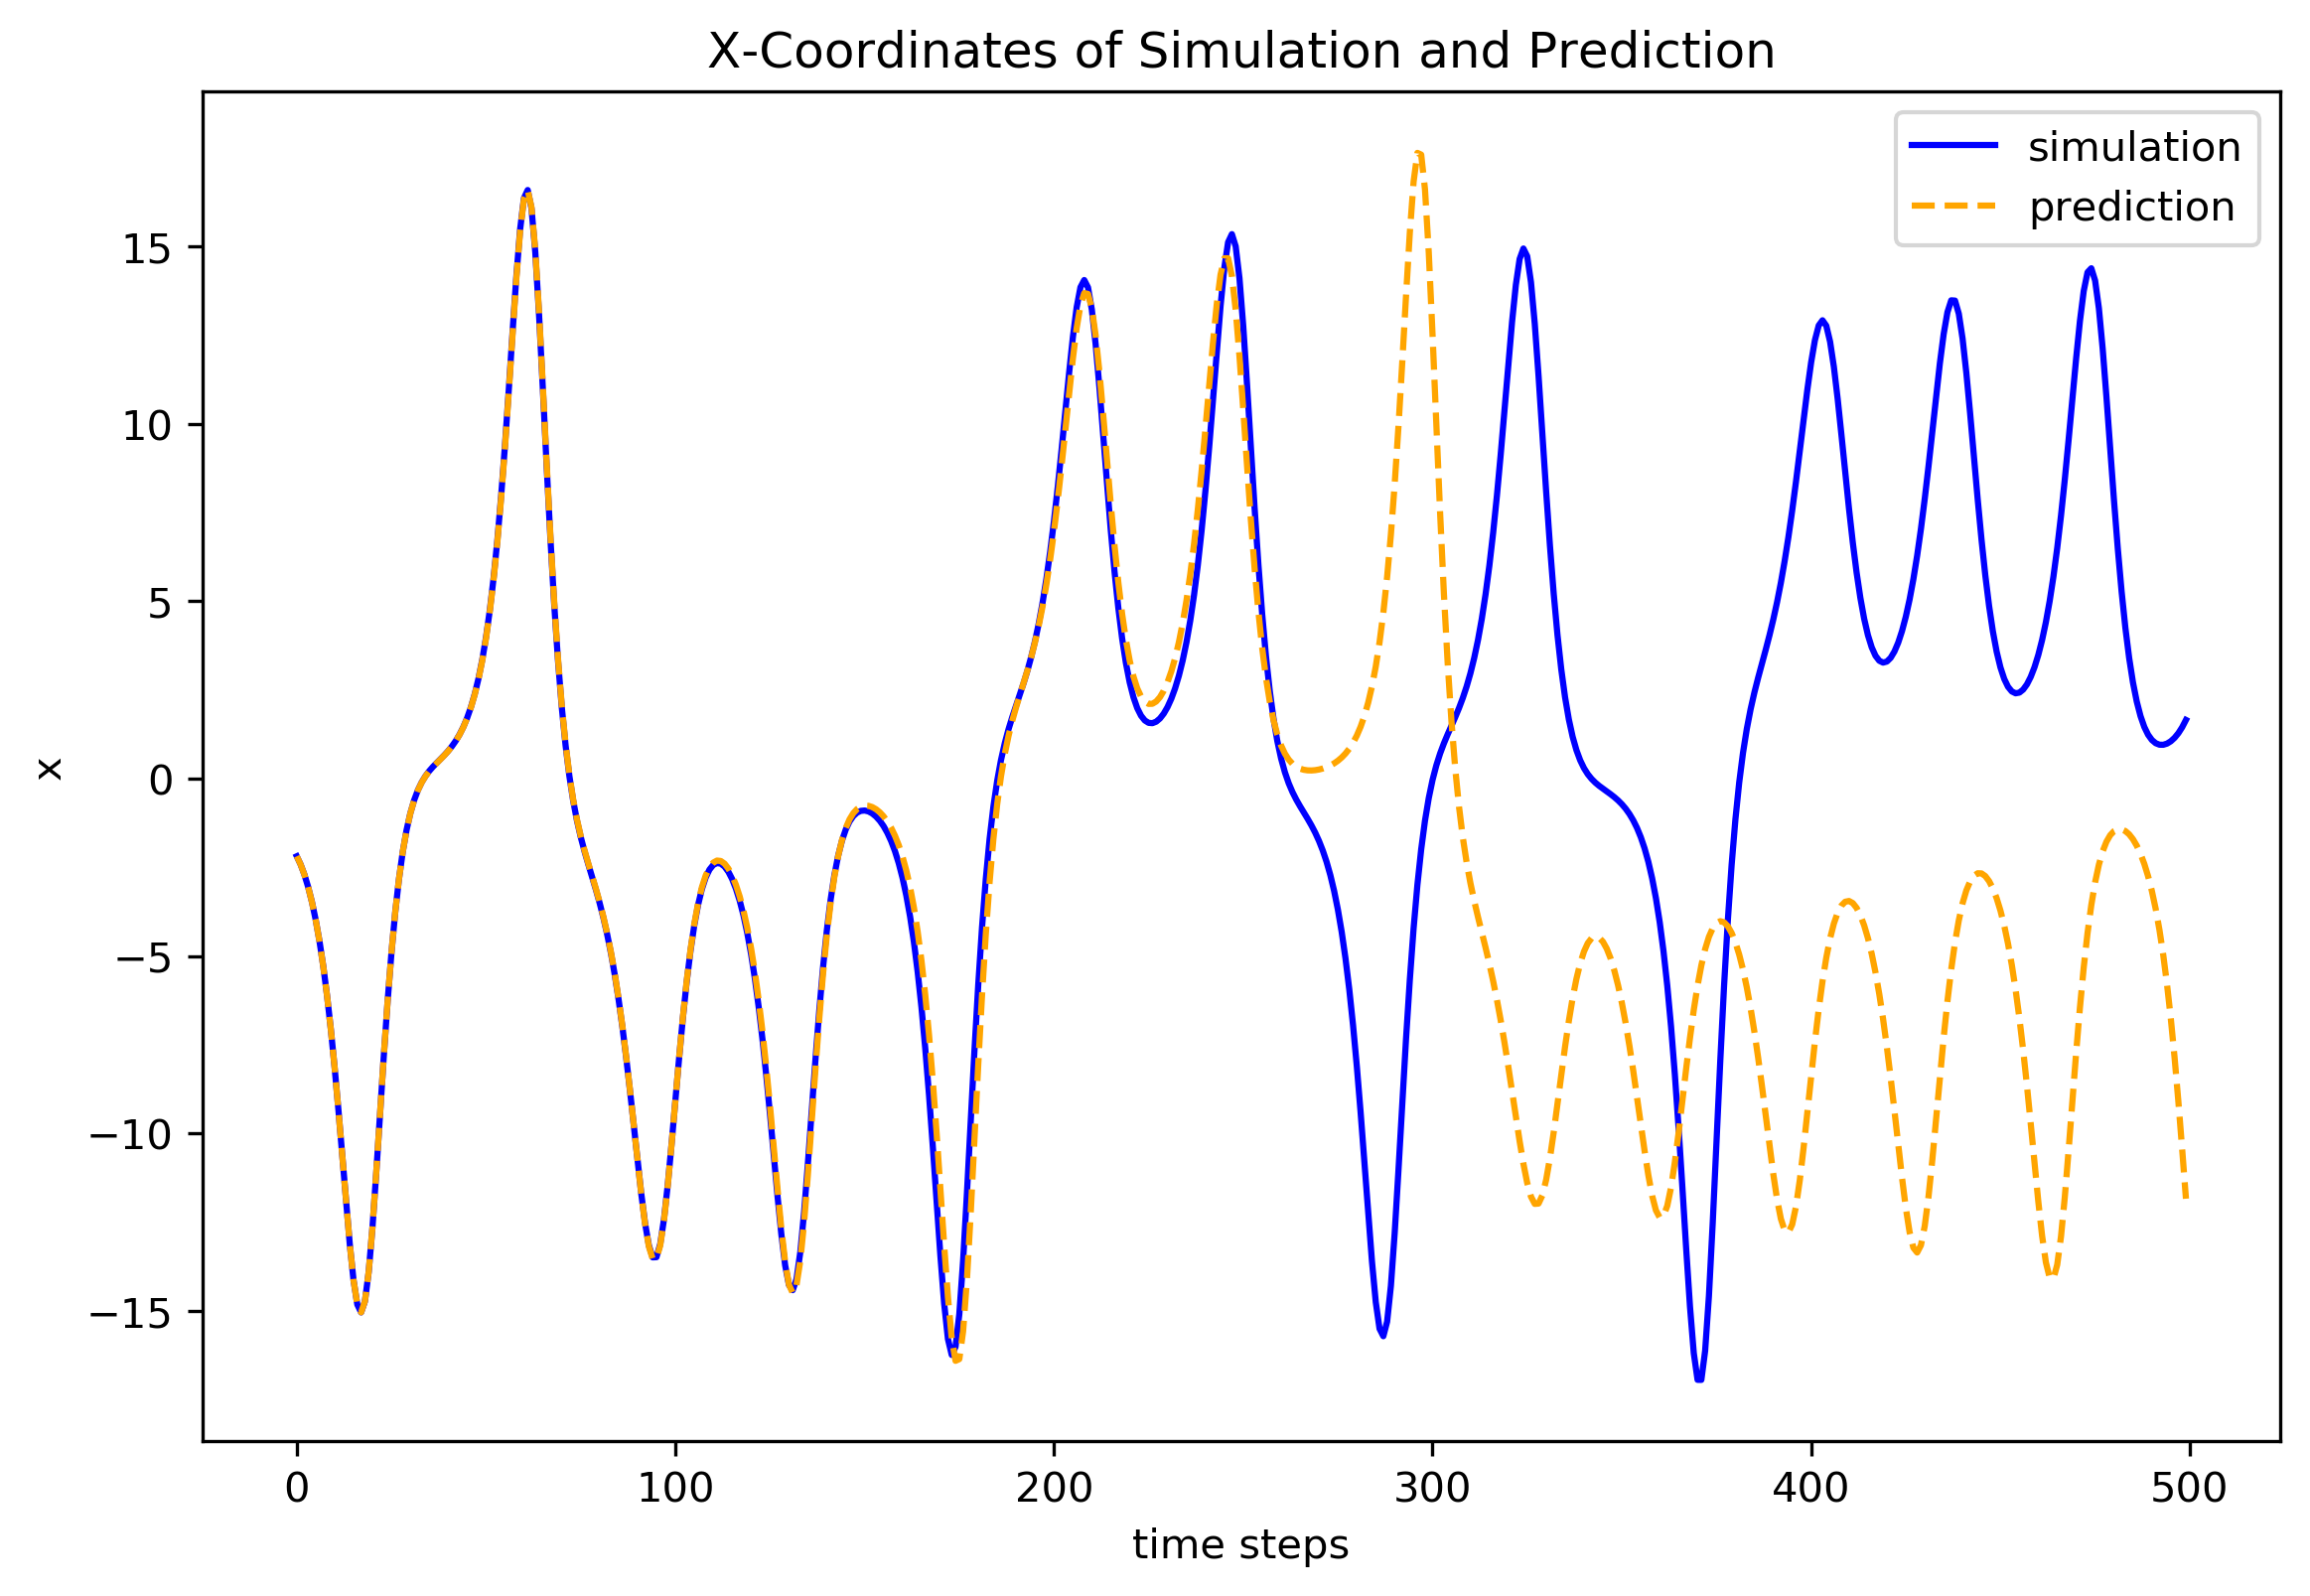

In [10]:
fig1 = plt.figure(figsize=(9, 6), dpi=300)
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(y_test[:, 0], 
         color='blue', label='simulation')
ax1.plot(y_pred[:, 0], 
         color='orange', linestyle='--', label='prediction')

ax1.set_xlabel('time steps')
ax1.set_ylabel('x')
ax1.set_title("X-Coordinates of Simulation and Prediction")
plt.legend()
plt.show()

Note that the prediction in the plot above does, of course, not start at time 
step 0 of the simulated data.  
To make clear what range of time steps we are actually looking at in the plots,
let's shift the time-steps-axis accordingly.

First, note that the prediction starts AFTER the synchronization, i.e. from the 
initial point 

> x_pred[pred_sync_steps + 1]

which we can prove via:

In [10]:
np.array_equal(x_pred[pred_sync_steps + 1], y_test[0])

True

This shift by 1 must always be the case as the predictions _y_ are the reservoir 
output after one prediction step, which necessarily increments the time by one 
step:

> x[t] -> RC prediction step -> y[t]

i.e. the input x[t] is used to calculate the output y[t] and hence, when comparing them to the underlying simulated data, the x-inputs 
and y-outputs are always shifted by this one time step:

> x: |0,1,2,3,4,...]  
> y: |-,0,1,2,3,4,...]

The first time step of the prediction y_pred corresponds to time step nr. _shift + pred_sync_steps + 1_ of the simulated data:

> "shift": the 10000 time steps we shifted the prediction input x_pred by in cell 
> [7]  
> "+ pred_sync_steps": the time steps used to synchronize the reservoir before the 
> prediction starts  
> "+ 1": the one time step resulting from the above explained shift of x and y by 1

Prove that this is true:

In [11]:
np.array_equal(sim_data[shift + pred_sync_steps + 1], y_test[0])

True

We can now define the correct time step range for the plot, starting at   

> shift + pred_sync_steps + 1  


and ending at  


> shift + pred_sync_steps + pred_steps + 1  

In [12]:
time_step_range = np.arange(shift + pred_sync_steps + 1, 
                            shift + pred_sync_steps + pred_steps + 1)

Now, let's plot the prediction again, this time with the correct time steps on the axis

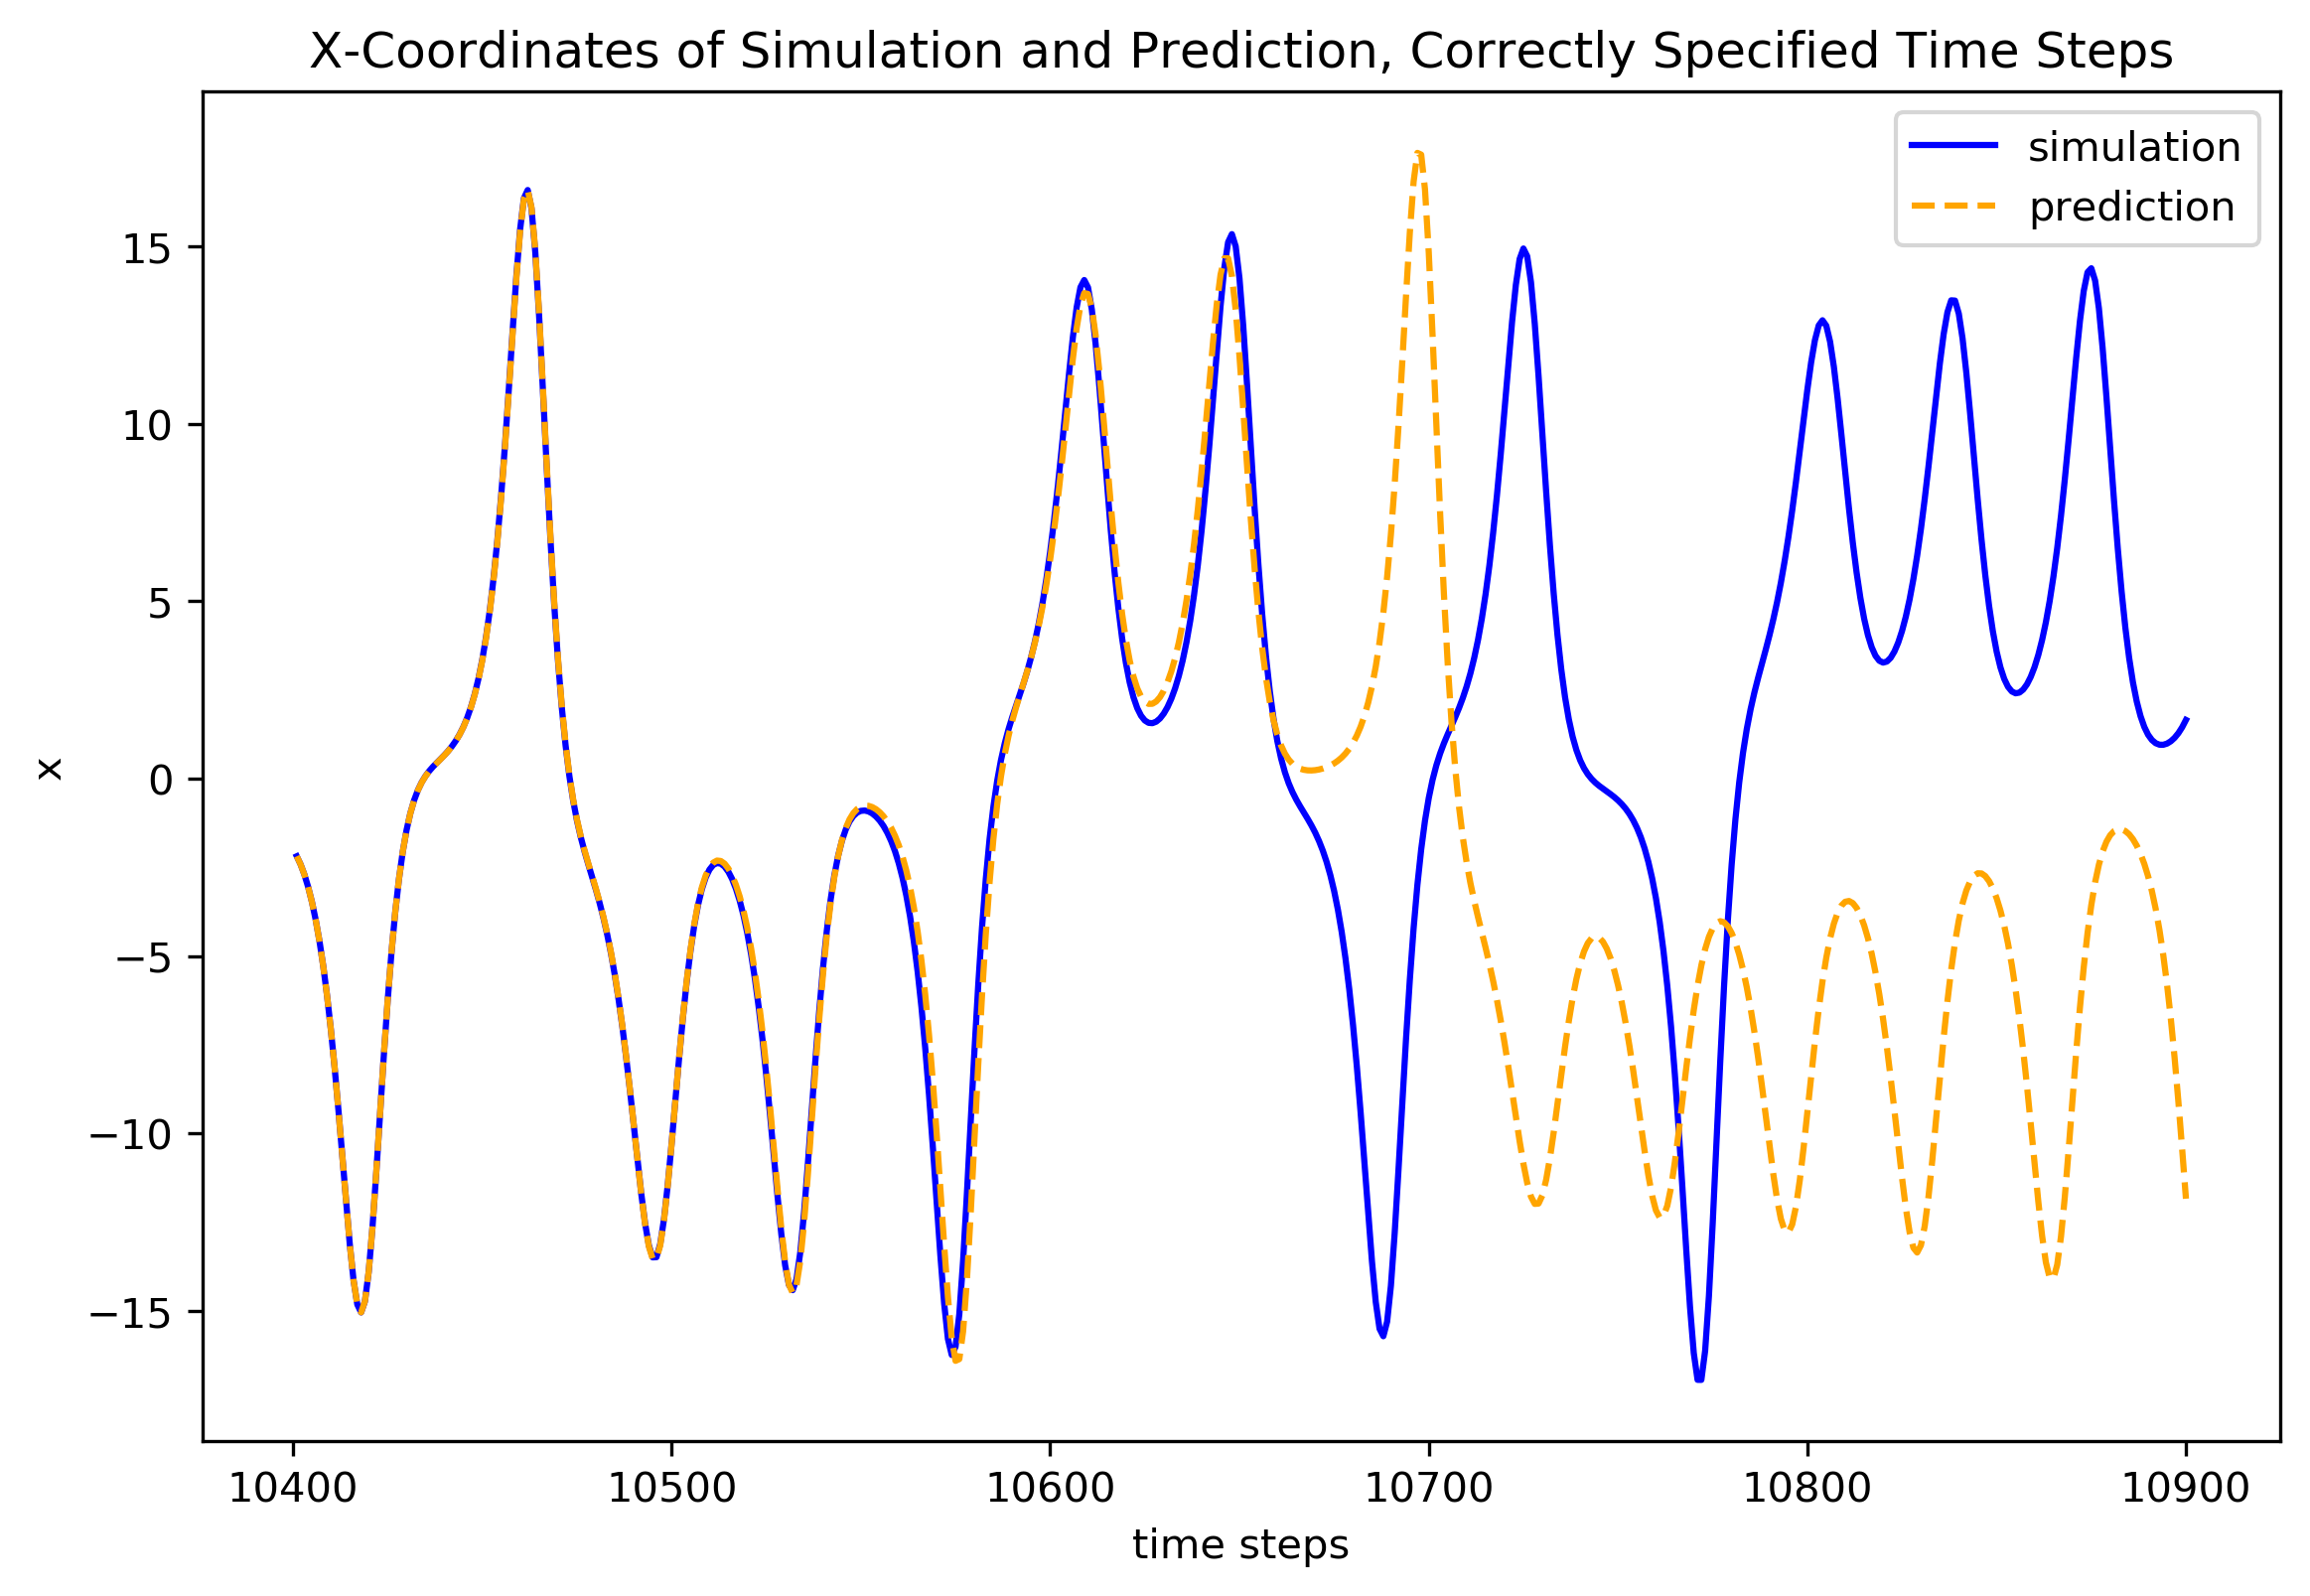

In [13]:
fig1 = plt.figure(figsize=(9, 6), dpi=300)
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(time_step_range, y_test[:, 0], 
         color='blue', label='simulation')
ax1.plot(time_step_range, y_pred[:, 0], 
         color='orange', linestyle='--', label='prediction')

ax1.set_xlabel('time steps')
ax1.set_ylabel('x')
ax1.set_title("X-Coordinates of Simulation and Prediction, "
              "Correctly Specified Time Steps")
plt.legend()
plt.show()

Let's do another prediction, this time after 15000 time steps:

In [14]:
shift2 = 15000
x_pred2 = sim_data[shift2:]
y_pred2, y_test2 = esn.predict(x_pred=x_pred2, sync_steps=pred_sync_steps,
                               pred_steps=pred_steps)

time_step_range2 = np.arange(shift2 + pred_sync_steps + 1, 
                            shift2 + pred_sync_steps + pred_steps + 1)

Note that we do not need to re-_train_ our reservoir if we want to predict the
same system from a different starting point again. We do need to _synchronize_ 
it every time though.

Plot the second prediction, again with the appropriately shifted time-step-axis.

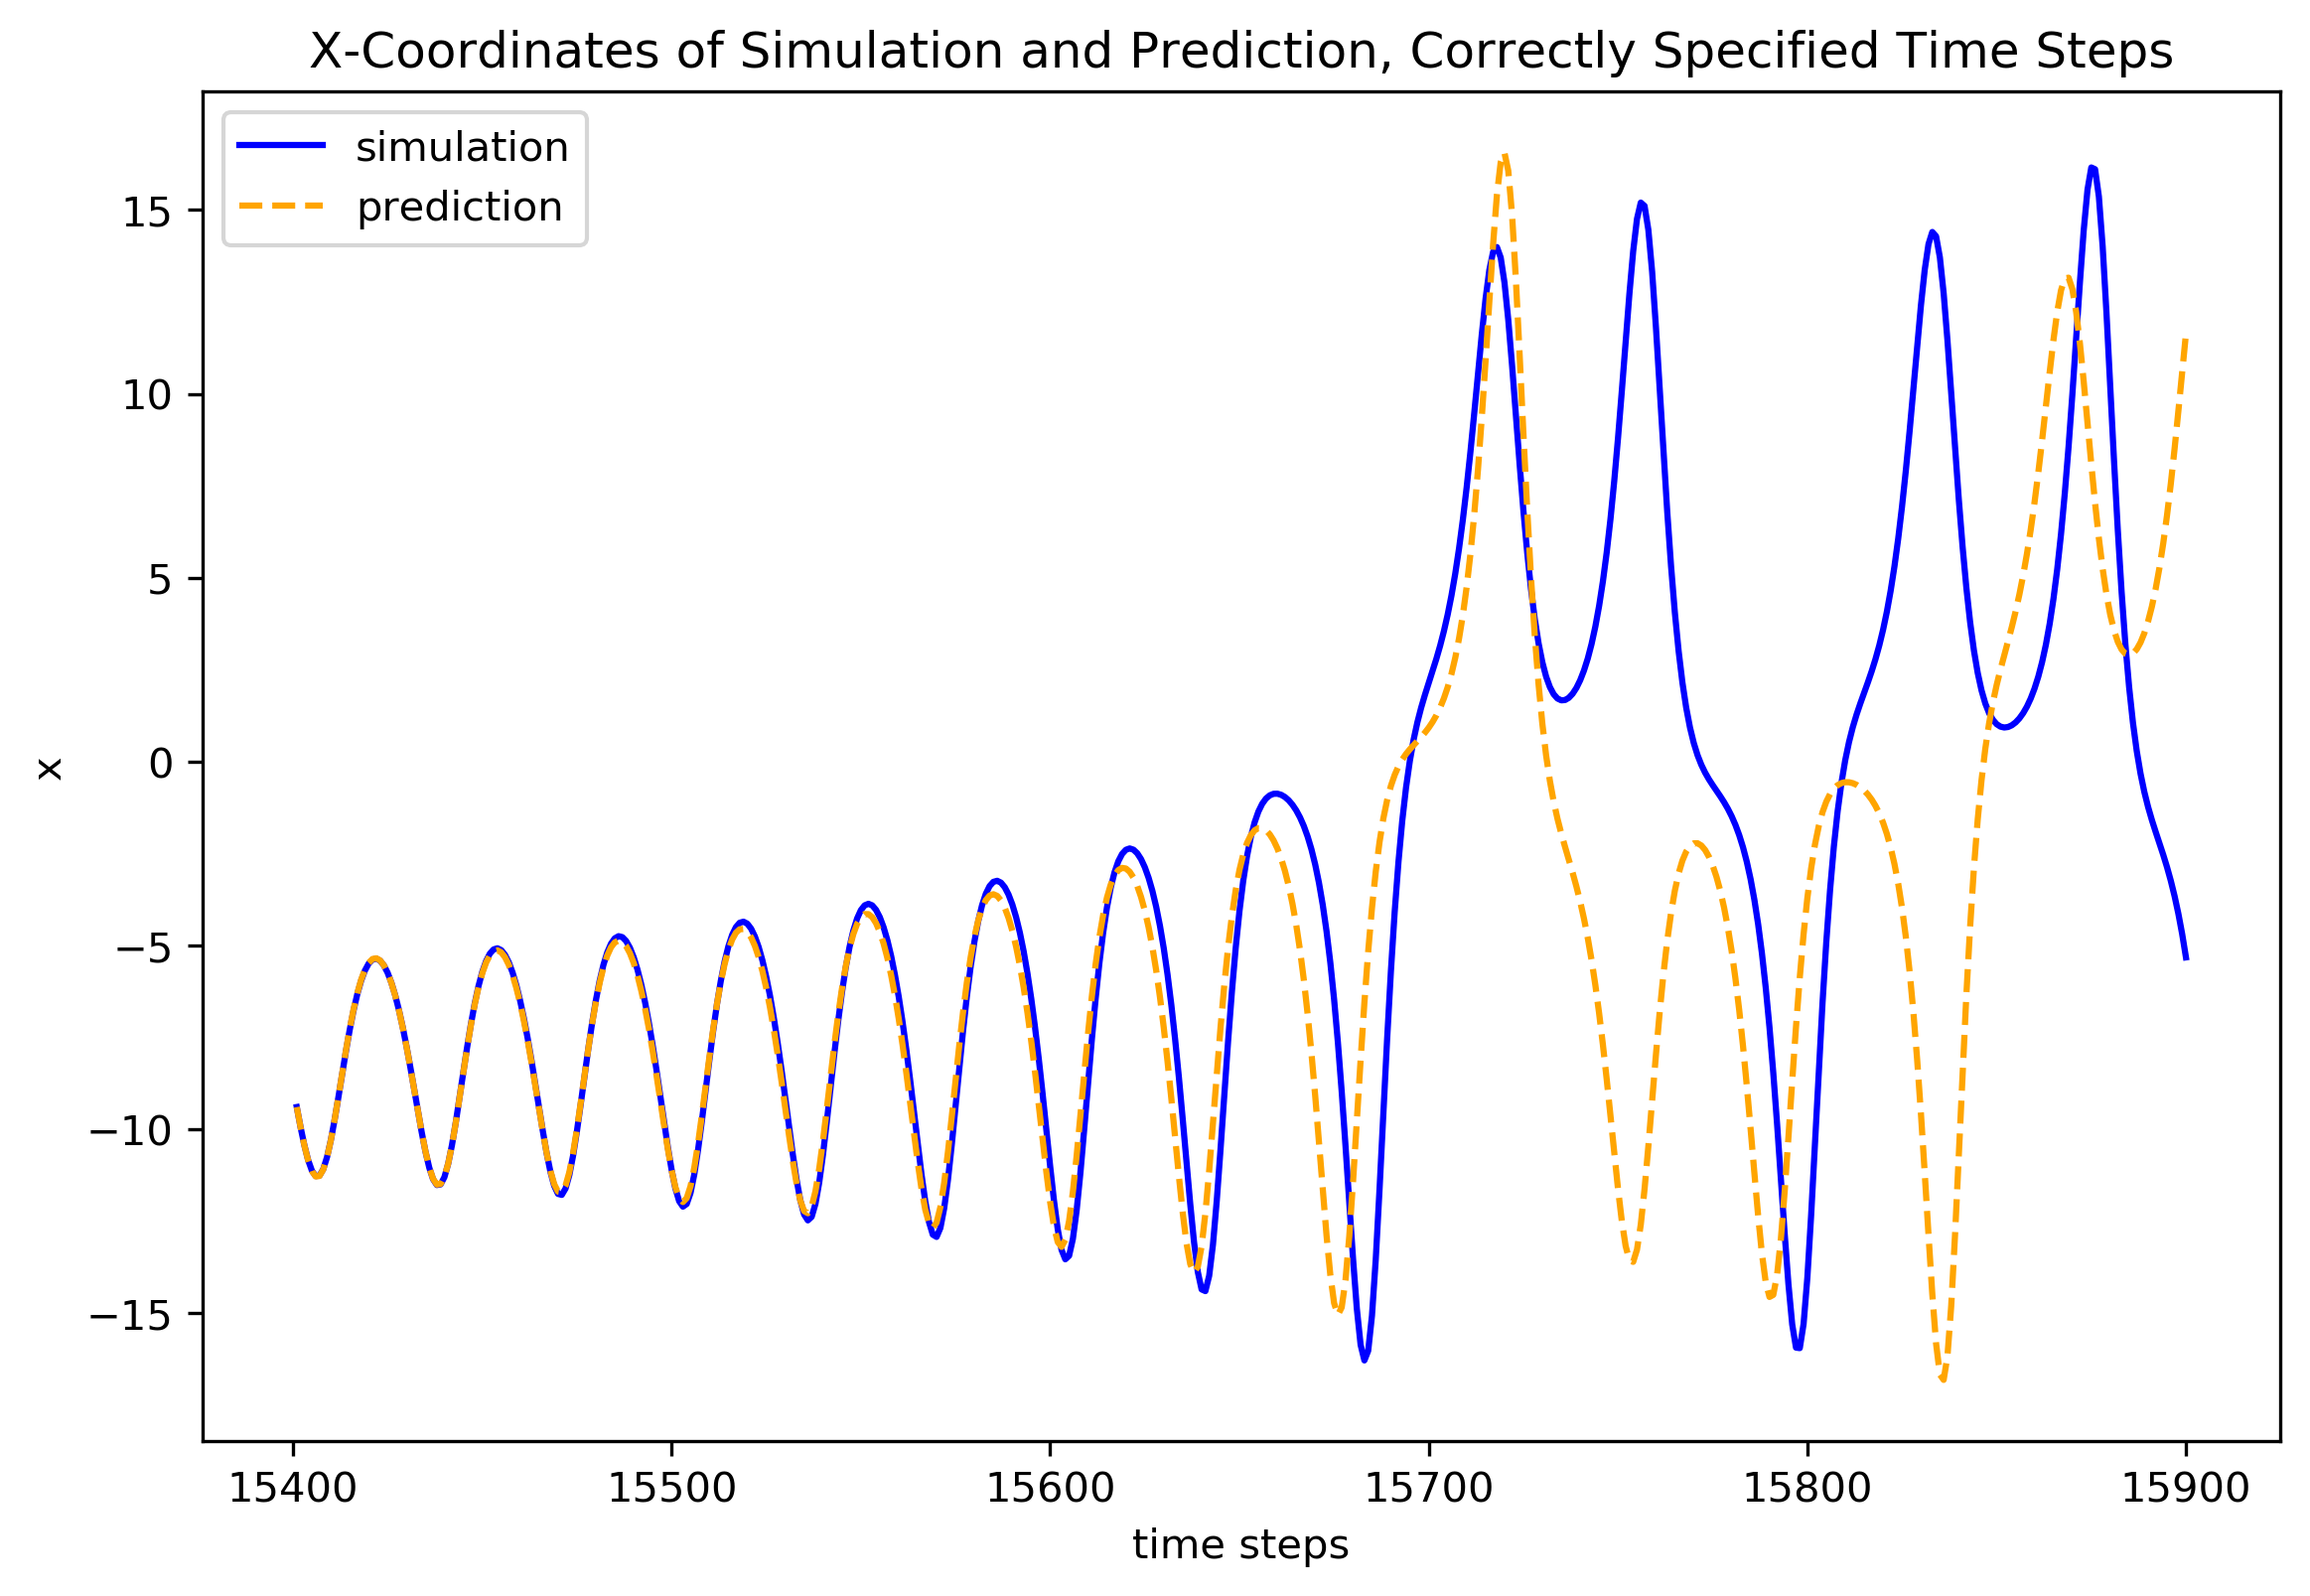

In [15]:
fig2 = plt.figure(figsize=(9, 6), dpi=300)
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(time_step_range2, y_test2[:, 0], 
         color='blue', label='simulation')
ax2.plot(time_step_range2, y_pred2[:, 0], 
         color='orange', linestyle='--', label='prediction')

ax2.set_xlabel('time steps')
ax2.set_ylabel('x')
ax2.set_title("X-Coordinates of Simulation and Prediction, "
              "Correctly Specified Time Steps")
plt.legend()
plt.show()